In [31]:
import matplotlib.pyplot as plt

In [32]:
import numpy as np

In [33]:
from scipy import stats

In [34]:
import ROOT
from ROOT import gROOT

## Set TDR styles
#gROOT.LoadMacro("tdrstyle.C")
##gROOT.ProcessLine("setTDRStyle();")

## Add CMS text
#gROOT.LoadMacro("CMS_lumi.C")
##gROOT.ProcessLine("CMS_lumi(c1);")

In [35]:
import CMS_lumi, tdrstyle
from array import array

#set the tdr style
tdrstyle.setTDRStyle()

In [36]:
from PasOrPaper import doPAS

In [37]:
#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = 1
if doPAS:
    CMS_lumi.extraText = "Simulation Preliminary"
else:
    CMS_lumi.extraText = "Simulation"
CMS_lumi.lumi_sqrtS = "(13 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
#CMS_lumi.lumi_sqrtS = ""

iPos = 11
iPos = 0
if( iPos==0 ): CMS_lumi.relPosX = 0.12

In [38]:
H_ref = 600; 
W_ref = 800; 
W = W_ref
H  = H_ref

# 
# Simple example of macro: plot with CMS name and lumi text
#  (this script does not pretend to work in all configurations)
# iPeriod = 1*(0/1 7 TeV) + 2*(0/1 8 TeV)  + 4*(0/1 13 TeV) 
# For instance: 
#               iPeriod = 3 means: 7 TeV + 8 TeV
#               iPeriod = 7 means: 7 TeV + 8 TeV + 13 TeV 
#               iPeriod = 0 means: free form (uses lumi_sqrtS)
# Initiated by: Gautier Hamel de Monchenault (Saclay)
# Translated in Python by: Joshua Hardenbrook (Princeton)
# Updated by:   Dinko Ferencek (Rutgers)
#

iPeriod = 3

# references for T, B, L, R
T = 0.08*H_ref
B = 0.15*H_ref 
L = 0.16*W_ref
R = 0.04*W_ref

canvas = ROOT.TCanvas("c2","c2",50,50,W,H)
canvas.SetFillColor(0)
canvas.SetBorderMode(0)
canvas.SetFrameFillStyle(0)
canvas.SetFrameBorderMode(0)
canvas.SetLeftMargin( L/W )
canvas.SetRightMargin( R/W )
canvas.SetTopMargin( T/H )
canvas.SetBottomMargin( B/H )
canvas.SetTickx(1)
canvas.SetTicky(1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


In [39]:
def TimeAnaSONIC(filename, timesSONIC):
    f = open(filename, 'r')
    Lines = f.readlines()
    t = []
    nb = 0
    for line in Lines:
        try:
            t.append(float(line))
        except:
            if('Traceback' in line):
                nb+=1
    timesSONIC.append(t)

In [40]:
timesSONIC = []
model = []
sonicFileNumbers = []
nfilesSONIC = []

model.append('splitServer_JustAK4_noRagged_Nov9')
sonicFileNumbers.append(['_60_1gpu_PT', '_100_1gpu_PT', '_120_1gpu_PT', '_148_1gpu_PT', '_180_1gpu_PT'])

model.append('splitServer_JustDM_Nov4')
sonicFileNumbers.append(['_400_1gpu_noCompress', '_452_1gpu_noCompress', '_500_1gpu_noCompress', '_552_1gpu_noCompress', '_572_1gpu_noCompress', '_600_1gpu_noCompress'])

model.append('splitServer_JustDT_TRT')
sonicFileNumbers.append([67252, 66837, 67117, 67049]) #just TRT

model.append('splitServer_JustAK8_noRagged_Nov9')
sonicFileNumbers.append(['_142_1gpu_PT', '_180_1gpu_PT', '_208_1gpu_PT', '_240_1gpu_PT'])#, '_252_1gpu_PT'])

for m in range(len(model)):
    nfilesSONIC.append(len(sonicFileNumbers[m]))
    timesSONIC.append([])

In [41]:
for m in range(len(model)):
    for sf in sonicFileNumbers[m]:
        TimeAnaSONIC('slurm_'+model[m]+'/Synchro'+str(sf)+'.txt', timesSONIC[m])

In [42]:
sortedJobs = []
for m in range(len(model)):
    nJobs = []
    for i in range(nfilesSONIC[m]):
        nJobs.append(len(timesSONIC[m][i]))
    sortedJobs.append(np.argsort(nJobs))


In [43]:
allns = []
allmeans = []
allstds = []
allstdsx = []
alllocs = []

for m in range(len(model)):
    n = nfilesSONIC[m]
    means = array('d')
    stds = array( 'd' )
    stdsx = array( 'd' )
    locs = array( 'd' )
 
    for f in range(nfilesSONIC[m]):
        means.append(np.median(timesSONIC[m][f]))
        stds.append(stats.sem(timesSONIC[m][f]))
        stdsx.append(0.)
        if(len(timesSONIC[m][f]) in locs):
            locs.append((len(timesSONIC[m][f])+.1))
        else:
            locs.append(len(timesSONIC[m][f]))
            
    allns.append(n)
    allmeans.append(means)
    allstds.append(stds)
    allstdsx.append(stdsx)
    alllocs.append(locs)

In [44]:
graphs = []
colors = [1,4,2,3]
styles = [20, 21, 22, 23]

for m in range(len(model)):
    gr = ROOT.TGraphErrors( allns[m], alllocs[m], allmeans[m], allstdsx[m], allstds[m] )
    graphs.append(gr)
for m in range(len(model)):
    graphs[m].SetLineColor( colors[m] )
    graphs[m].SetLineWidth( 2 )
    graphs[m].SetMarkerColor( colors[m] )
    graphs[m].SetMarkerStyle( styles[m] )
    if(m==0):
        graphs[m].SetTitle( 'a simple graph' )
        graphs[m].GetXaxis().SetTitle( 'Number of synchronized 4-threaded jobs' )
        graphs[m].GetXaxis().SetTitleFont(42)
        graphs[m].GetXaxis().SetTitleSize(0.06)
        graphs[m].GetXaxis().SetLimits(40, 600)
        graphs[m].GetYaxis().SetTitle( 'Throughput [evt/s]' )
        graphs[m].GetYaxis().SetTitleFont(42)
        graphs[m].GetYaxis().SetTitleSize(0.06)
        graphs[m].GetYaxis().SetRangeUser(3.4, 4.4)        
        graphs[m].Draw( 'ALP, same' )
    else:
        graphs[m].Draw('LP,same')

In [45]:
testLine = ROOT.TLine(50, 3.88, 600, 3.88)
testLine.SetLineStyle(2)
testLine.SetLineWidth(2)
#testLine.Draw('same')
testLine.Draw()

#testLine2 = ROOT.TLine(45, 3.49, 53, 3.49)
#testLine2.SetLineStyle(2)
#testLine2.SetLineWidth(2)
#testLine2.Draw('same')

"""
xlabel = ROOT.TText();
xlabel.SetNDC();
xlabel.SetTextFont(1);
xlabel.SetTextColor(1);
xlabel.SetTextFont(42)
xlabel.SetTextSize(0.035);
xlabel.SetTextAlign(22);
xlabel.SetTextAngle(0);
xlabel.DrawText(0.5, 0.22, "Avg throughput of ''Direct-inference'' = 3.88 evt/s");
#xlabel.Draw('same')
"""

'\nxlabel = ROOT.TText();\nxlabel.SetNDC();\nxlabel.SetTextFont(1);\nxlabel.SetTextColor(1);\nxlabel.SetTextFont(42)\nxlabel.SetTextSize(0.035);\nxlabel.SetTextAlign(22);\nxlabel.SetTextAngle(0);\nxlabel.DrawText(0.5, 0.22, "Avg throughput of \'\'Direct-inference\'\' = 3.88 evt/s");\n#xlabel.Draw(\'same\')\n'

In [50]:
legend = ROOT.TLegend(0.20,0.7,0.85,0.9);
#legend.SetHeader("The Legend Title","C"); // option "C" allows to center the header
legend.AddEntry(graphs[0],"PyTorch PN-AK4","pl");
legend.AddEntry(graphs[1],"DeepMET","pl");
legend.AddEntry(graphs[2],"DeepTau with TRT","pl");
legend.AddEntry(graphs[3],"PyTorch PN-AK8 (3 models on 1 GPU)","pl");
#legend.AddEntry(testLine, "Avg throughput of ''Direct-inference'' = 3.88 evt/s", "l")
legend.AddEntry(testLine, 'Average of CPU "direct-inference" jobs', "l")
#gStyle.SetLegendBorderSize(1);
#gStyle.SetLegendFillColor(0);
legend.SetTextFont(42);
legend.SetTextSize(0.035);
legend.Draw('same');
#legend.Draw();

In [51]:
#CMS_lumi.CMS_lumi( canvas, iPeriod, iPos )
CMS_lumi.CMS_lumi( canvas, 0, iPos )

(13 TeV)


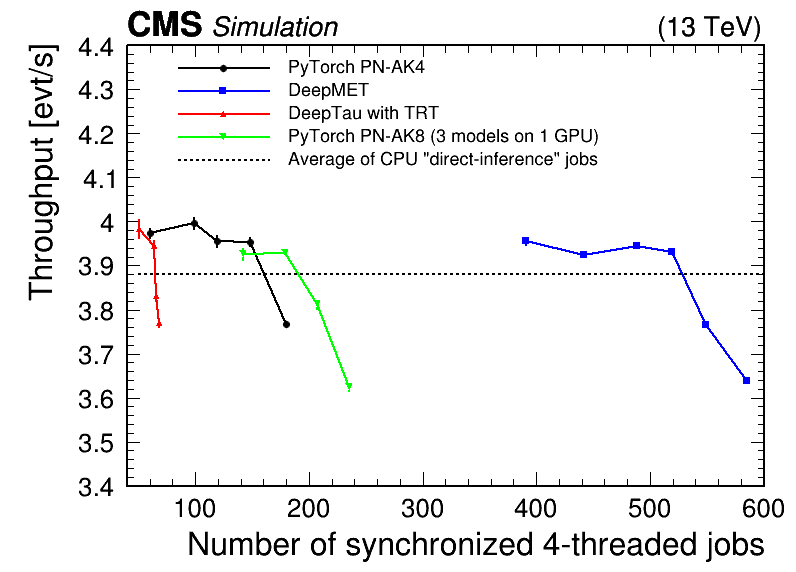

In [52]:
#canvas.SetLogx()
#canvas.SetRange(1, 2000)
#canvas.Update()
canvas.Draw()

In [53]:
#canvas.SaveAs('plots_for_DPS/'+"PN_throughput_scan_PT.pdf")
canvas.SaveAs("plots/Figure_008.pdf")

Info in <TCanvas::Print>: pdf file plots/Figure_008.pdf has been created
